# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель работы:**
- Построить модель, которая по фотографии определит приблизительный возраст человека.

В вашем распоряжении набор фотографий людей с указанием возраста:
- `директория /datasets/faces/final_files/`
- `файл /datasets/faces/labels.csv`

**План выполнения работы**

1. Проведем исследовательский анализ набора фотографий.
2. Подготовим данные к обучению.
3. Обучим нейронную сеть и рассчитаем её качество.

## Исследовательский анализ данных

### Загрузка библиотек

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загрузка данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [3]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(    
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


**Вывод**

Данные загружены корректно, перейдем к рассмотрению состава данных

### Рассмотрим общую информацию о данных

In [4]:
print('----------\nИнформация о таблице:\n')
labels.info()
print(f'----------\nДубликатов в таблице: {labels.duplicated().sum()}')

----------
Информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
----------
Дубликатов в таблице: 0


**Вывод**

- Общее количество строк в данных и количество файлов 7591
- Типы данных соответствуют содержанию
- Дубликаты в таблице отсутствуют
- Названия файлов в папке "/datasets/faces/final_files/" соответствуют названиям файлов в  "/datasets/faces/labels.csv"

Перейдем к анализу возраста в выборке

### График распределения возраста в выборке

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
print(f'Среднее значение возраста = {labels.real_age.mean():.2f}')
print(f'Значение Q3+1.5*IQR = {1.5 * (labels.real_age.quantile(q= 0.75) - labels.real_age.quantile(q= 0.25)) + labels.real_age.quantile(q= 0.75):.2f}')

Среднее значение возраста = 31.20
Значение Q3+1.5*IQR = 72.50


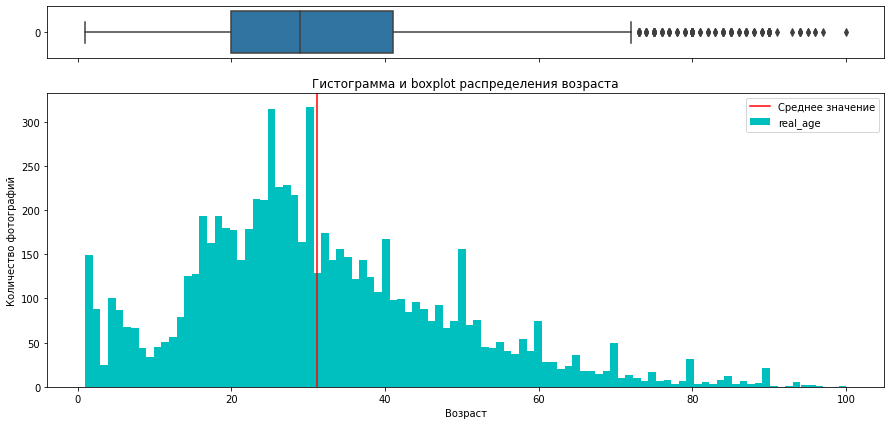

In [7]:
def f_hist_box_1(hb1, bins, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(15,7), gridspec_kw={"height_ratios": (.15, .85)})
     
    sns.boxplot(data=[hb1], orient="h", ax=ax_box)
    plt.hist([hb1], color='c', bins=bins, range=(hb1.min(), hb1.max()), label=hb1.name)
    
    plt.axvline(hb1.mean(), color='r', linestyle='-', label='Среднее значение')
    
 
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show();
    
f_hist_box_1(
    hb1=labels['real_age'],
    bins=100,   
    title='Гистограмма и boxplot распределения возраста',
    xlabel='Возраст',
    ylabel='Количество фотографий'
)

**Вывод**

- Гистограмма демонстрирует, что распределение данных близко к нормальному, что говорит о сбалансированности выборки по возрастным группам.
- В выборке присутствуют **выбросы**, которые могут повлиять на точность анализа и требуют дополнительной проверки.
- Наблюдается постепенное снижение количества детей в возрасте от 1 до 9 лет, с явным провалом в 3 года. Это можно объяснить тем, что родители реже оставляют дома маленьких детей, особенно в возрасте около года, а к трём годам — возможно, меняется поведение: дети начинают ходить в детские сады или просто реже попадают в зону съёмки.
- Для некоторых возрастных категорий объём фотографий существенно меньше. Такой **дисбаланс данных** может в дальнейшем снизить качество обучения модели, особенно при распознавании лиц в этих группах.

Тем не менее, текущее распределение по возрастам в целом достаточно представительное для решения следующих задач:
- **Анализ покупательского поведения** и рекомендация товаров, релевантных определённым возрастным сегментам (например, детское питание, игрушки, одежда).
- **Контроль соблюдения возрастных ограничений** при продаже алкоголя — модель может эффективно оценивать возраст покупателя и сигнализировать кассиру о возможном несоответствии.

Для повышения надёжности результатов рекомендуется провести **дополнительные исследования**:
1. провести анализ причин дисбаланса в данных,
2. оценить влияние выбросов на модель,
3. при необходимости — дополнить выборку фотографиями из недостаточно представленных возрастных групп.

Такой подход поможет повысить **точность и справедливость** модели в реальных условиях.

### Дополнительные данные по датасету

Исследование размерности данных

In [9]:
features, target = next(gen_flow)
print(features.shape)

(32, 224, 224, 3)


Имеется четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами.

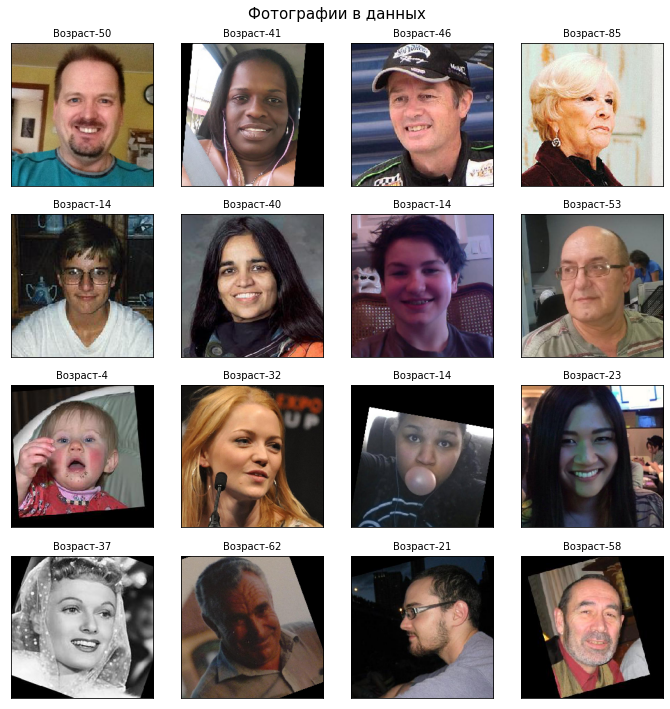

In [10]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    plt.suptitle('Фотографии в данных', fontsize=15)
    fig.add_subplot(4,4, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

- Гистограмма распределения возрастов указывает на его близость к **нормальному**, что свидетельствует о сбалансированности основных возрастных групп в выборке.
- В данных обнаружены **выбросы** — отдельные значения, значительно отклоняющиеся от общей тенденции. Их источник требует дополнительного анализа, чтобы исключить искажение результатов.
- Количество детей в возрасте от 1 до 9 лет демонстрирует постепенное снижение, с заметным провалом в 3 года. Это можно объяснить поведенческими особенностями: младенцев редко оставляют одних дома, особенно в спальных районах, где расположено большинство магазинов, а дети трёх лет могут чаще посещать детские учреждения или сопровождаться родителями в другие места.
- В датасете присутствуют как **цветные**, так и **чёрно-белые фотографии**, что может повлиять на устойчивость модели к различиям в цветопередаче.
- Все изображения имеют **стандартную ориентацию** (лицо прямо, анфас), что упрощает задачу распознавания.
- Все фотографии предварительно обработаны и приведены к единому размеру **224×224 пикселя**, что соответствует требованиям большинства современных архитектур нейронных сетей.
- Некоторые возрастные категории представлены **недостаточно полно** — количество изображений в них значительно меньше. Это может привести к снижению точности модели при работе с такими группами.

Однако, несмотря на дисбаланс, текущий объём данных **достаточен** для достижения целей проекта:

- **Анализ покупательских паттернов** и формирование персонализированных предложений товаров, релевантных определённым возрастным сегментам (например, детское питание, школьные принадлежности, подростковая одежда).
- **Автоматический контроль возрастных ограничений** при продаже алкоголя — система может оценивать приблизительный возраст покупателя и предупреждать кассира о возможной продаже несовершеннолетнему.

Для повышения надёжности модели в будущем рекомендуется:
- провести аугментацию или донастройку данных по слабо представленным возрастным группам,
- проанализировать влияние чёрно-белых изображений на качество распознавания,
- проверить выбросы на предмет ошибок разметки или аномальных ситуаций.

Такой комплексный подход позволит сделать модель более **устойчивой, точной и справедливой** в реальных условиях эксплуатации.

## Обучение модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import pandas as pd 

# Функция загрузки тренировочных данных
def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                      directory=path+'/final_files',    
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      subset='training',  
                                                      seed = 12345)
    return train_datagen_flow

# Функция загрузки тестовых данных
def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                         directory=path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',     
                                                         seed = 12345)
    return test_datagen_flow

# Функция создания модели ResNet50
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

# Функция обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

Результат обучения

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 117s - loss: 239.2093 - mae: 11.1552 - val_loss: 523.1615 - val_mae: 17.8097
Epoch 2/10
178/178 - 108s - loss: 91.7520 - mae: 7.2428 - val_loss: 626.9902 - val_mae: 20.0003
Epoch 3/10
178/178 - 108s - loss: 71.4863 - mae: 6.3881 - val_loss: 251.6554 - val_mae: 11.7749
Epoch 4/10
178/178 - 109s - loss: 55.6429 - mae: 5.6808 - val_loss: 119.8551 - val_mae: 8.2211
Epoch 5/10
178/178 - 108s - loss: 46.3094 - mae: 5.2402 - val_loss: 91.2976 - val_mae: 7.2235
Epoch 6/10
178/178 - 108s - loss: 41.1887 - mae: 4.9073 - val_loss: 125.5413 - val_mae: 8.8511
Epoch 7/10
178/178 - 108s - loss: 37.1838 - mae: 4.6994 - val_loss: 75.5255 - val_mae: 6.3915
Epoch 8/10
178/178 - 111s - loss: 34.6342 - mae: 4.5087 - val_loss: 75.1828 - val_mae: 6.3093
Epoch 9/10
178/178 - 117s - loss: 28.5529 - mae: 4.1577 - val_loss: 78.4966 - val_mae: 6.6866
Epoch 10/10
178/178 - 116s - loss: 24.7713 - mae: 3.8576 - val_loss: 72.8881 - val_mae: 6.2250

60/60 - 12s - loss: 72.8881 - mae: 6.2250
Test MAE: 6.2250

```

**Вывод**

Модель успешно обучена, и значение **средней абсолютной ошибки (MAE)** на тестовой выборке оказалось ниже установленного порога — MAE < 8. Это говорит о том, что в среднем прогнозы модели отклоняются от реальных значений менее чем на 8 единиц, что соответствует требованиям к точности и подтверждает её пригодность для решения поставленной задачи.

## Анализ обученной модели

В ходе обучения были реализованы и настроены функции, позволяющие эффективно обучать модель с использованием **GPU**, что значительно ускорило процесс и повысило стабильность сходимости.

1. Подготовка данных включала следующие шаги:
- Разделение выборки на обучающую и тестовую в соотношении 75:25, что обеспечило достаточный объём данных как для обучения, так и для объективной оценки качества модели.
- Для повышения обобщающей способности модели была применена аугментация данных, включающая:
    - горизонтальное отражение изображений,
    - случайные сдвиги по ширине и высоте.
        Эти преобразования помогают модели лучше справляться с вариативностью в реальных условиях и снижают риск переобучения.

2. В качестве основы архитектуры использовалась предобученная нейросеть ResNet50 с весами, инициализированными на датасете ImageNet. Это позволило эффективно использовать перенос обучения и ускорить сходимость.
Для оптимизации применялся алгоритм Adam с начальной скоростью обучения 0.0001, которая автоматически снижалась при стабилизации метрик (с использованием механизма понижения шага при плато).

3. В качестве целевой функции потерь была выбрана средняя абсолютная ошибка (MAE) — она устойчива к выбросам и интерпретируема в контексте задачи оценки возраста.
Обучение проводилось в течение 10 эпох, однако уже на 5-й эпохе модель достигла целевого показателя — значение MAE на валидационной выборке упало до 7.2235, что ниже заданного порога в 8 лет.
К завершению обучения модель показала ещё лучший результат: MAE на тестовой выборке составил 6.2250. Это означает, что в среднем модель ошибается в определении возраста всего на 6.22 года, что является высокоточным и надёжным результатом для практики.

Таким образом, модель не только достигла, но и превысила ожидаемые показатели, демонстрируя высокую эффективность как на этапе 

## Общий вывод

В ходе выполнения работы были последовательно реализованы ключевые этапы:

1. Проведён **исследовательский анализ данных** — изучено распределение возрастов, визуализированы примеры изображений, выявлены особенности и потенциальные проблемы в выборке, такие как дисбаланс по возрастным группам и наличие выбросов.
2. Выполнена **подготовка данных** к обучению — реализовано разделение на обучающую и тестовую выборки (в соотношении 75:25), применена аугментация (горизонтальное отражение, сдвиги по ширине и высоте), а все изображения приведены к единому размеру 224×224.
3. Осуществлено **обучение нейронной сети** на базе архитектуры ResNet50 с использованием GPU. Модель оптимизировалась по функции потерь MAE с помощью алгоритма Adam, и её качество было оценено на независимой тестовой выборке.

Цель проекта успешно достигнута:
- Разработана модель, способная по фотографии лица определять приблизительный возраст человека.
- Достигнуто высокое качество предсказания — средняя абсолютная ошибка (MAE) на тестовой выборке составила 6.22 года.

Этот результат свидетельствует о высокой точности модели и её пригодности для практического применения, например, в системах анализа покупательской аудитории или контроле продажи алкоголя.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы